In [1]:
# General Data Cleaning/Stats
import pandas as pd
import numpy as np
import re

from datetime import datetime

# General Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Tree Visualisation
import pydot    # conda install pydoty
from sklearn.tree import export_graphviz
from IPython.display import Image
from dtreeviz.trees import dtreeviz # pip install dtreeviz

In [2]:
# hyperopt - used for Bayesian hyperparameter tuning
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope  # conda install -c conda-forge hyperopt

# for timing
from time import time

In [3]:
sns.set_palette("rocket")
pal = sns.color_palette("rocket")
hex_colors = pal.as_hex()
print(hex_colors)
pal

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

## 1. Preparing Data

In [4]:
df_all = pd.read_csv("data/final_restaurant_rating_data.csv")

In [5]:
# ------------------- Will shift to feature engineering notebook --------------------- #

for idx, row in df_all[df_all['average_rating'].isna()].iterrows():
    df_all.loc[idx, "average_rating_category"] = 0

for idx, row in df_all[df_all['average_daily_operating_hours'].isna()].iterrows():
    df_all.loc[idx, "average_daily_operating_hours"] = 0

for idx, row in df_all[df_all['total_operating_hours'] < 0].iterrows():
    df_all.loc[idx, "total_operating_hours"] = 24 * 7 - row['total_operating_hours']

#### Grouping of Variables (to manage)

In [6]:
target_rating_variable = [
    # 'overall_rating',
    # 'average_rating',
    'average_rating_category',
]

region_ohe = [
    'region_bedok',
    'region_bishan_toa_payoh',
    'region_bugis_city_hall',
    'region_bukit_merah_southern_islands',
    'region_bukit_timah',
    'region_changi',
    'region_downtown',
    'region_geylang',
    'region_kallang',
    'region_marina_bay',
    'region_marina_centre',
    'region_newton_orchard',
    'region_north_region',
    'region_northeast_region',
    'region_novena',
    'region_outram',
    'region_paya_lebar_tampines_pasir_ris',
    'region_queenstown',
    'region_rochor',
    'region_singapore_river',
    'region_tanglin',
    'region_west_region',
]

nearby_attraction_ohe = [
    'nearby_attraction_arab_street',
    'nearby_attraction_boat_quay',
    'nearby_attraction_chinatown',
    'nearby_attraction_east_coast_park',
    'nearby_attraction_garden',
    'nearby_attraction_little_india',
    'nearby_attraction_marina_bay',
    'nearby_attraction_merlion_park',
    'nearby_attraction_museum',
    'nearby_attraction_observation',
    'nearby_attraction_orchard_road',
    'nearby_attraction_wildlife',
    'nearby_attraction_nan',
]

nearby_attraction_feature_cross = [
    'nearby_attraction_arab_street_above_median',
    'nearby_attraction_boat_quay_above_median',
    'nearby_attraction_chinatown_above_median',
    'nearby_attraction_east_coast_park_above_median',
    'nearby_attraction_garden_above_median',
    'nearby_attraction_little_india_above_median',
    'nearby_attraction_marina_bay_above_median',
    'nearby_attraction_merlion_park_above_median',
    'nearby_attraction_museum_above_median',
    'nearby_attraction_observation_above_median',
    'nearby_attraction_orchard_road_above_median',
    'nearby_attraction_wildlife_above_median',
]

meal_ohe = [
    'meal_lunch',
    'meal_dinner',
    'meal_drinks',
    'meal_breakfast',
    'meal_brunch',
    'meal_after_hours',
    'has_meals',
]

cuisine_ohe = [
    'cuisine_arabic',
    'cuisine_asian',
    'cuisine_chinese',
    'cuisine_european',
    'cuisine_indian',
    'cuisine_international',
    'cuisine_italian',
    'cuisine_japanese',
    'cuisine_south_american',
    'cuisine_north_american',
    'cuisine_others',
    'cuisine_sea',
    'has_cuisines',
]

feature_ohe = [
    'feature_delivery',
    'feature_reservations',
    'feature_outdoor_seating',
    'feature_seating',
    'feature_highchairs_available',
    'feature_digital_payments',
    'feature_free_wifi',
    'feature_cash_only',
    'feature_wheelchair_accessible',
    'feature_table_service',
    'feature_live_music',
    'feature_parking_avail',
    'feature_alcohol_avail',
    'feature_creditcard_avail',
    'has_features',    
]

diet_ohe = [
    'diet_vegetarian_friendly',
    'diet_vegan_options',
    'diet_gluten_free_options',
    'diet_halal',    
]

train_station_ohe = [
    'nearest_train_line_color_blue',
    'nearest_train_line_color_green',
    'nearest_train_line_color_others',
    'nearest_train_line_color_purple',
    'nearest_train_line_color_red',
    'nearest_train_line_color_yellow',    
]

price_features=  [
    'has_price_category',
    'price_category',
]

other_features = [
    'average_sentiment_score',
    'img_uploaded_per_review',
    'proportion_of_positive_sentiment',
    'is_travellors_choice',
    'is_michellin',
    'is_in_mall',
    'walking_distance',
    'above_median_dist_from_nearby_attraction'
]

operating_hours_featueres = [
    'total_operating_hours',
    'num_of_days_open',
    'average_daily_operating_hours',
    'operates_on_weekends',
    'operates_on_sat_or_sun',
    'has_operating_hours'
]

In [7]:
dct_feature_category = {}

for col in region_ohe:
    dct_feature_category[col] = "Region OHE"

for col in nearby_attraction_ohe:
    dct_feature_category[col] = "Nearby Attraction OHE"

for col in nearby_attraction_feature_cross:
    dct_feature_category[col] = "Nearby Attraction Feature Cross"

for col in meal_ohe:
    dct_feature_category[col] = "Meal OHE"

for col in cuisine_ohe:
    dct_feature_category[col] = "Cuisine OHE"

for col in feature_ohe:
    dct_feature_category[col] = "Feature OHE"

for col in diet_ohe:
    dct_feature_category[col] = "Diet OHE"

for col in train_station_ohe:
    dct_feature_category[col] = "Nearest Train Station Color OHE"    

for col in train_station_ohe:
    dct_feature_category[col] = "Nearest Train Station Color OHE"    

for col in price_features:
    dct_feature_category[col] = "Price Features"

for col in operating_hours_featueres:
    dct_feature_category[col] = "Operating Hours Features"

for col in other_features:
    dct_feature_category[col] = re.sub("_", " ", col).title()


In [8]:
df = df_all[
    target_rating_variable +
    region_ohe +
    price_features +
    nearby_attraction_ohe +
    nearby_attraction_feature_cross +
    meal_ohe +
    cuisine_ohe +
    feature_ohe +
    diet_ohe +
    train_station_ohe +
    operating_hours_featueres +
    other_features
].copy()

In [9]:
df.shape

(7192, 109)

### Cleaning of Column Dtype

In [10]:
for col in region_ohe + nearby_attraction_ohe + nearby_attraction_feature_cross + cuisine_ohe + train_station_ohe:
    if col in df.columns:
        df[col] = df[col].astype('int64')

In [11]:
np.unique(np.array([df[col].dtype for col in df[target_rating_variable +
                                                region_ohe +
                                                price_features +
                                                nearby_attraction_ohe +
                                                nearby_attraction_feature_cross +
                                                meal_ohe +
                                                cuisine_ohe +
                                                feature_ohe +
                                                diet_ohe +
                                                train_station_ohe
                                                ].columns if col in df.columns]))

array([dtype('int64')], dtype=object)

In [12]:
df['is_in_mall'] = df['is_in_mall'].astype('int64')

In [13]:
print(df[other_features + operating_hours_featueres].dtypes)

average_sentiment_score                     float64
img_uploaded_per_review                     float64
proportion_of_positive_sentiment            float64
is_travellors_choice                          int64
is_michellin                                  int64
is_in_mall                                    int64
walking_distance                            float64
above_median_dist_from_nearby_attraction    float64
total_operating_hours                       float64
num_of_days_open                              int64
average_daily_operating_hours               float64
operates_on_weekends                          int64
operates_on_sat_or_sun                        int64
has_operating_hours                           int64
dtype: object


### Scaling / Normalising
- Not used for Random Forest

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
features_to_standardise = [
    'average_sentiment_score',
    'img_uploaded_per_review',
    'proportion_of_positive_sentiment',
    'above_median_dist_from_nearby_attraction',
    'total_operating_hours',
    'average_daily_operating_hours',
    'walking_distance'
]

features_no_need_to_standardise = [col for col in df.columns if col not in features_to_standardise]

In [16]:
df.shape # --> 7191

(7192, 109)

In [17]:
for col in features_to_standardise:
    if col in df.columns:
        print(f"Proportion of Missing Values of {col}:")
        print("{:.2f}%".format(len(df[df[col].isna()]) / len(df) * 100))

Proportion of Missing Values of average_sentiment_score:
0.01%
Proportion of Missing Values of img_uploaded_per_review:
0.01%
Proportion of Missing Values of proportion_of_positive_sentiment:
0.01%
Proportion of Missing Values of above_median_dist_from_nearby_attraction:
0.00%
Proportion of Missing Values of total_operating_hours:
0.00%
Proportion of Missing Values of average_daily_operating_hours:
0.00%
Proportion of Missing Values of walking_distance:
0.00%


In [19]:
# --- Drop NA (for average_sentiment_score)
df.dropna(subset=['average_sentiment_score'], inplace=True)

In [ ]:
# df_scale = df[features_no_need_to_standardise].copy()

# sc = StandardScaler()

# for col in features_to_standardise:
#     scaled_numbers = sc.fit_transform(df[[col]])
#     df_scale[col] = scaled_numbers

# df = df_scale.copy()    

## 2. Initial Model Feature Selection

### Features to Exclude from All Features
- Proportion of Positive Sentiment is excluded because of its close link to Average Sentiment Score
- Average Daily Operating Hours is excluded because of its direct derivation from Total Operating Hours and Number of Days Open

In [20]:
# ------------------- Feature Selection Cell --------------------- #

features_to_exclude = [
    # price features
    # 'has_price_category',
    # 'price_category',

    # other features
    # 'average_sentiment_score',
    # 'img_uploaded_per_review',
    'proportion_of_positive_sentiment',
    # 'is_travellors_choice',
    # 'is_michellin',
    # 'is_in_mall',
    # 'walking_distance',
    # 'above_median_dist_from_nearby_attraction',
    
    # operating hours
    # 'total_operating_hours',
    # 'num_of_days_open',
    'average_daily_operating_hours',
    # 'operates_on_weekends',
    # 'operates_on_sat_or_sun',
    # 'has_operating_hours'
]

# features_to_exclude.extend(region_ohe)
# features_to_exclude.extend(nearby_attraction_ohe)
# features_to_exclude.extend(nearby_attraction_feature_cross)
# features_to_exclude.extend(train_station_ohe)

# features_to_exclude.extend(meal_ohe)
# features_to_exclude.extend(cuisine_ohe)
# features_to_exclude.extend(feature_ohe)
# features_to_exclude.extend(diet_ohe)

In [21]:
df = df.drop(columns=features_to_exclude)

### Separate Test Data (Not used for Modelling)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
target = ["average_rating_category"]
features = list(df.columns)
features.remove("average_rating_category")

In [24]:
X, X_holdout, y, y_holdout = train_test_split(df[features], 
                                                df[target], 
                                                test_size=0.15, 
                                                random_state=2022, 
                                                shuffle=True, 
                                                stratify=df[target])

In [25]:
X.shape

(6112, 106)

In [26]:
X_holdout.shape

(1079, 106)

## 3. Helper Functions for Modelling

In [27]:
# model learning models
from sklearn.ensemble import RandomForestClassifier

# tools
import pickle

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                            f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, \
                            ConfusionMatrixDisplay, RocCurveDisplay


### Helper Function to evaluate Model Performance

In [28]:
def evaluate_results(y_test, y_pred, y_proba, plot_confusion_matrix=True, plot_roc=False, title="Classification Results"):
    '''
    This is a helper function that we will call to print basic results statistics.
    '''
    # Create confusion matrix of validation data
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    print("Confusion Matrix:")
    if plot_confusion_matrix:
        disp = ConfusionMatrixDisplay(cm, display_labels=["Poor [0]", "Excellent [1]"])
        disp.plot(cmap=plt.cm.OrRd)
        plt.title(title,pad=5)
        plt.show()
    else:
        print(cm)
    print("TN: %s, FP: %s, FN: %s, TP: %s" %(TN, FP, FN, TP))

    # Evaluation Statistics
    # Performance of decision tree model on validation data
    print("Accuracy: {:.5f}".format(accuracy_score(y_test, y_pred)))
    print("Recall: {:.5f}".format(recall_score(y_test, y_pred)))
    print("Precision: {:.5f}".format(precision_score(y_test, y_pred)))
    print("F1: {:.5f}".format(f1_score(y_test, y_pred)))
    print("ROC_AUC: {:.5f}".format(roc_auc_score(y_test, y_proba)))      # pass in probability
    
    if plot_roc:
        disp = RocCurveDisplay.from_predictions(y_test,y_proba)
        plt.show()

### Helper Function to perform Model Training with Cross Validation

In [29]:
from sklearn.model_selection import StratifiedKFold

In [30]:
def stratified_k_fold_model_fit(X, Y, model, splits=5, shuffle=False, verbose=True, plot_confusion_matrix=True, plot_roc=True, hide_fold_result=False, title=None):
    X = np.array(X)
    Y = np.array(Y)

    if shuffle:
        kf = StratifiedKFold(n_splits=splits, shuffle=shuffle, random_state=2022)
        kf.get_n_splits(X, Y)
    else:
        kf = StratifiedKFold(n_splits=splits, shuffle=shuffle)
        kf.get_n_splits(X, Y)
    
    # ----- Test ----- #
    auc_scores = [] # AUC scores
    all_y_preds = [] # predictions
    all_y_proba = [] # probabilities
    all_y_true = [] # true labels

    # ----- Train ----- #
    train_auc_scores = [] # AUC scores
    train_y_preds = [] # predictions
    train_y_proba = [] # probabilities
    train_true = [] # true labels

    for train, test in kf.split(X, Y):
        # get the current train and test sets (for this particular fold)
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]
        
        model_fit = model.fit(X_train, Y_train.ravel())

        # predict on training set
        y_pred_train = model_fit.predict(X_train)
        y_proba_train = model_fit.predict_proba(X_train)
        train_y_preds.extend(y_pred_train)
        train_y_proba.extend(y_proba_train[:, 1])
        train_true.extend(Y_train)
        
        # predict on validation set
        # y_pred = model_fit.predict(X_test)
        y_proba = model_fit.predict_proba(X_test)
        y_pred = [1 if y_prob >= 0.5 else 0 for y_prob in y_proba[:, 1]]

        if verbose and not hide_fold_result:
            print('-'*20 + ' Fold Result' + '-'*20)
            evaluate_results(Y_test, y_pred, y_proba[:, 1], plot_confusion_matrix=False, plot_roc=False, title=title)

        all_y_preds.extend(y_pred)
        all_y_proba.extend(y_proba[:, 1])
        all_y_true.extend(Y_test)
    
    # Evaluate results
    if verbose:
        print('-'*20 + ' Overall Train Result' + '-'*20)
        evaluate_results(train_true, train_y_preds, train_y_proba, plot_confusion_matrix=plot_confusion_matrix, plot_roc=plot_roc, title=title)
        print('-'*20 + ' Overall Test Result' + '-'*20)
        evaluate_results(all_y_true, all_y_preds, all_y_proba, plot_confusion_matrix=plot_confusion_matrix, plot_roc=plot_roc, title=title)
        
    return roc_auc_score(train_true, train_y_proba), roc_auc_score(all_y_true, all_y_proba)

### Helper Function to save model performance

In [31]:
# This cell contains helper functions to save tuning results.
if not os.path.exists('Tuning'): os.mkdir('Tuning')
    
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

## 3. Model Training

### Baseline Model Comparison (Bagging vs Boosting)

In [32]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 

##### Decision Tree

In [33]:
base_decision_tree = DecisionTreeClassifier(
    max_depth=None,             # default
    criterion="entropy",
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


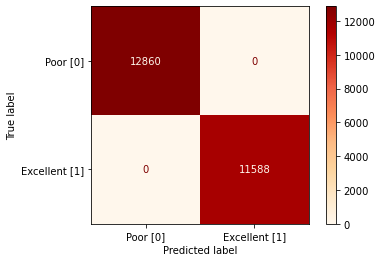

TN: 12860, FP: 0, FN: 0, TP: 11588
Accuracy: 1.00000
Recall: 1.00000
Precision: 1.00000
F1: 1.00000
ROC_AUC: 1.00000


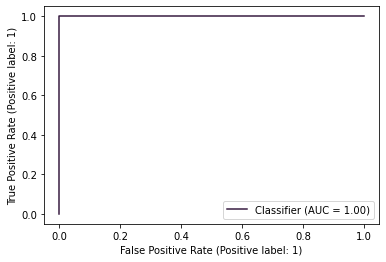

-------------------- Overall Test Result--------------------
Confusion Matrix:


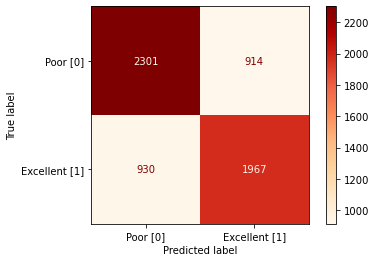

TN: 2301, FP: 914, FN: 930, TP: 1967
Accuracy: 0.69830
Recall: 0.67898
Precision: 0.68275
F1: 0.68086
ROC_AUC: 0.69734


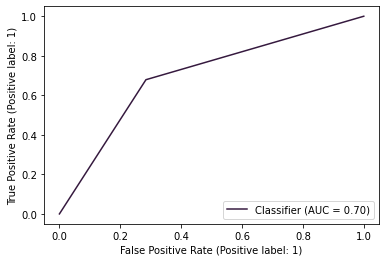

In [34]:
roc_auc_train_ada_boost, roc_auc_test_ada_boost = stratified_k_fold_model_fit(X, y, base_decision_tree, 5, shuffle=True, hide_fold_result=True)

##### AdaBoost

In [35]:
adaboost = AdaBoostClassifier(
    base_decision_tree,
    n_estimators=100,           # default
    algorithm='SAMME.R',
    random_state=2022,
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


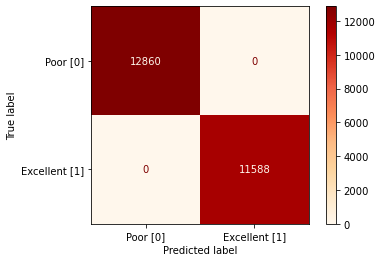

TN: 12860, FP: 0, FN: 0, TP: 11588
Accuracy: 1.00000
Recall: 1.00000
Precision: 1.00000
F1: 1.00000
ROC_AUC: 1.00000


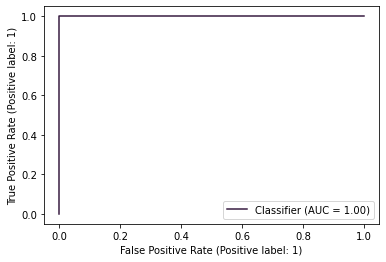

-------------------- Overall Test Result--------------------
Confusion Matrix:


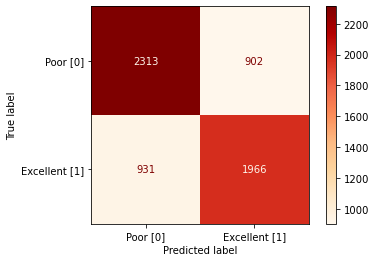

TN: 2313, FP: 902, FN: 931, TP: 1966
Accuracy: 0.70010
Recall: 0.67863
Precision: 0.68550
F1: 0.68205
ROC_AUC: 0.69904


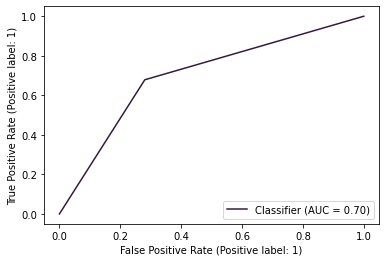

In [36]:
roc_auc_train_ada_boost, roc_auc_test_ada_boost = stratified_k_fold_model_fit(X, y, adaboost, 5, shuffle=True, hide_fold_result=True)

##### Random Forest

In [37]:
rf = RandomForestClassifier(
    n_estimators=100,           # default (to be tuned)
    max_depth=None,             # default (to be tuned)
    criterion="entropy",        # used in lecture
    random_state=2022,
    n_jobs=-1
)

-------------------- Fold Result--------------------
Confusion Matrix:
[[507 136]
 [145 435]]
TN: 507, FP: 136, FN: 145, TP: 435
Accuracy: 0.77024
Recall: 0.75000
Precision: 0.76182
F1: 0.75586
ROC_AUC: 0.84734
-------------------- Fold Result--------------------
Confusion Matrix:
[[526 117]
 [159 421]]
TN: 526, FP: 117, FN: 159, TP: 421
Accuracy: 0.77433
Recall: 0.72586
Precision: 0.78253
F1: 0.75313
ROC_AUC: 0.85148
-------------------- Fold Result--------------------
Confusion Matrix:
[[520 123]
 [149 430]]
TN: 520, FP: 123, FN: 149, TP: 430
Accuracy: 0.77741
Recall: 0.74266
Precision: 0.77758
F1: 0.75972
ROC_AUC: 0.83961
-------------------- Fold Result--------------------
Confusion Matrix:
[[505 138]
 [146 433]]
TN: 505, FP: 138, FN: 146, TP: 433
Accuracy: 0.76759
Recall: 0.74784
Precision: 0.75832
F1: 0.75304
ROC_AUC: 0.85701
-------------------- Fold Result--------------------
Confusion Matrix:
[[504 139]
 [143 436]]
TN: 504, FP: 139, FN: 143, TP: 436
Accuracy: 0.76923
Recall: 0

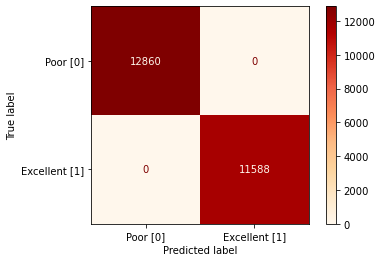

TN: 12860, FP: 0, FN: 0, TP: 11588
Accuracy: 1.00000
Recall: 1.00000
Precision: 1.00000
F1: 1.00000
ROC_AUC: 1.00000


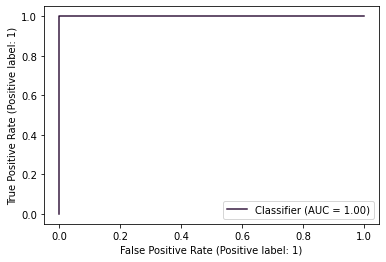

-------------------- Overall Test Result--------------------
Confusion Matrix:


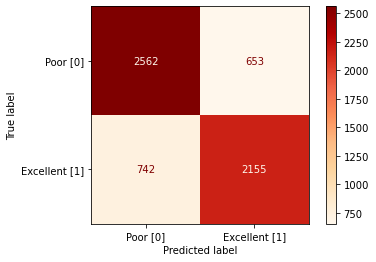

TN: 2562, FP: 653, FN: 742, TP: 2155
Accuracy: 0.77176
Recall: 0.74387
Precision: 0.76745
F1: 0.75548
ROC_AUC: 0.84874


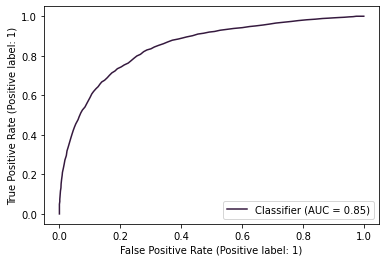

In [38]:
roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, rf, 5, shuffle=True, hide_fold_result=False)

<strong>Observations:</strong>
- Train AUC of 1.00 implies that model overfits train data since we did not limit the max_depth of the tree
- Fitting on Test data achieved a Cross Validated AUC_ROC of 0.769

### Hyper-Parameter Tuning to reduce Overfitting from Baseline Model

#### Tuning max_depth

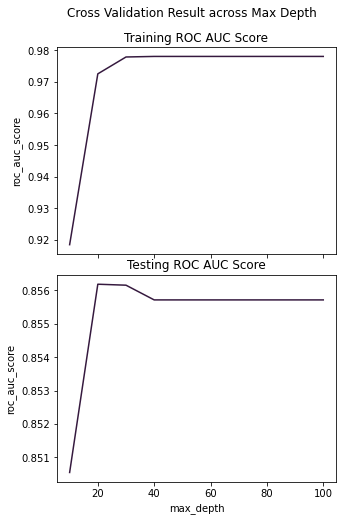

In [39]:
df_max_depth_tuning = pd.DataFrame()

# Zoom into: 10 - 30

for n in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    clf = RandomForestClassifier(
                n_estimators=100,           # default
                max_depth=n,             # default
                max_features="auto",        # default
                min_samples_split=3,        # do not want too little data in one split
                min_samples_leaf=3,         # do not want too little data in one leaf node
                criterion="entropy",        # covered in lecture
                bootstrap=True,
                oob_score=True,
                random_state=2022,
                n_jobs=-1
    )
    
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, 5, shuffle=True, verbose=False, plot_confusion_matrix=False, hide_fold_result=True, plot_roc=False)

    df_max_depth_tuning = df_max_depth_tuning.append(
            pd.DataFrame({
                    'max_depth': [n],
                    'train': [roc_auc_train],
                    'test': [roc_auc_test],
            })
    )

df_max_depth_tuning.set_index("max_depth", inplace=True)
df_max_depth_tuning = df_max_depth_tuning.stack().reset_index().rename(columns={"level_1": "result", 0: "roc_auc_score"})

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5,8))
fig.suptitle("Cross Validation Result across Max Depth", y=0.95)

sns.lineplot(
    ax=axes[0],
    data=df_max_depth_tuning[df_max_depth_tuning['result'] == 'train'],
    x='max_depth',
    y="roc_auc_score",
)
axes[0].set_title("Training ROC AUC Score")

sns.lineplot(
    ax=axes[1],
    data=df_max_depth_tuning[df_max_depth_tuning['result'] == 'test'],
    x='max_depth',
    y="roc_auc_score",
)
axes[1].set_title("Testing ROC AUC Score")

plt.subplots_adjust(hspace=0.1)
plt.show()

<strong>Observations:</strong>
- For both train and test data, we will be able to improve model performance by increasing the max_depth from 0 to 20.
- However as max_depth increases beyond 20, ROC AUC score of test data prediction decreases while that of the train data prediction increases which could imply that the model is over-fitting the training data.
- <strong>Optimal max_depth: 20</strong>

#### N_Estimators

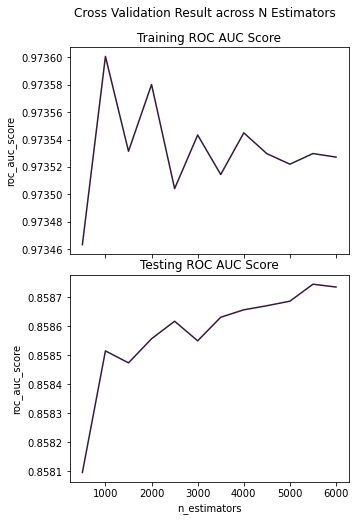

In [41]:
df_n_estimators_tuning = pd.DataFrame()

for n in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
    clf = RandomForestClassifier(
                n_estimators=n,
                max_depth=20,
                max_features="auto",
                min_samples_split=3,
                min_samples_leaf=3,
                criterion="entropy",
                bootstrap=True,
                oob_score=True,
                random_state=2022,
                n_jobs=-1
    )
    
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, 5, shuffle=True, verbose=False, plot_confusion_matrix=False, hide_fold_result=True, plot_roc=False)

    df_n_estimators_tuning = df_n_estimators_tuning.append(
            pd.DataFrame({
                    'n_estimators': [n],
                    'train': [roc_auc_train],
                    'test': [roc_auc_test],
            })
    )

df_n_estimators_tuning.set_index("n_estimators", inplace=True)
df_n_estimators_tuning = df_n_estimators_tuning.stack().reset_index().rename(columns={"level_1": "result", 0: "roc_auc_score"})

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5,8))
fig.suptitle("Cross Validation Result across N Estimators", y=0.95)

sns.lineplot(
    ax=axes[0],
    data=df_n_estimators_tuning[df_n_estimators_tuning['result'] == 'train'],
    x='n_estimators',
    y="roc_auc_score",
)
axes[0].set_title("Training ROC AUC Score")

sns.lineplot(
    ax=axes[1],
    data=df_n_estimators_tuning[df_n_estimators_tuning['result'] == 'test'],
    x='n_estimators',
    y="roc_auc_score",
)
axes[1].set_title("Testing ROC AUC Score")

plt.subplots_adjust(hspace=0.1)
plt.show()

<strong>Observations:</strong>
- Train ROC_AUC is highly irregular across n_estimators, with several "peaks" occuring at n_estimators of 1000, 2000, 3000 and 4000.
- Test ROC_AUC however increases sharpy from 0 to 1000, and increases gradually to a peak at 5000 n_estimators (with a slight dip at 3000 estimators).
- We will choose to train models using 4000 n_estimators as it will be able to learn more signals from the train data (one of the peaks identified) while achieving a high ROC_AUC on the test data as well.
- <strong>Optimal n_estimators: 4000</strong>

#### min_samples_leaf

In [42]:
df_min_samples_leaf_tuning = pd.DataFrame()

for n in [1, 10, 20, 30, 40, 50, 60]:
    clf = RandomForestClassifier(
                n_estimators=4000,          # default
                max_depth=20,               # from earlier
                max_features="auto",        # default
                min_samples_split=3,        # do not want too little data in one split
                min_samples_leaf=n,         
                criterion="entropy",        # covered in lecture
                bootstrap=True,
                oob_score=True,
                random_state=2022,
                n_jobs=-1
    )
    
    roc_auc_train, roc_auc_test = stratified_k_fold_model_fit(X, y, clf, 5, shuffle=True, verbose=False, plot_confusion_matrix=False, hide_fold_result=True, plot_roc=False)

    df_min_samples_leaf_tuning = df_min_samples_leaf_tuning.append(
            pd.DataFrame({
                    'min_samples_leaf': [n],
                    'train': [roc_auc_train],
                    'test': [roc_auc_test],
            })
    )

df_min_samples_leaf_tuning.set_index("min_samples_leaf", inplace=True)
df_min_samples_leaf_tuning = df_min_samples_leaf_tuning.stack().reset_index().rename(columns={"level_1": "result", 0: "roc_auc_score"})

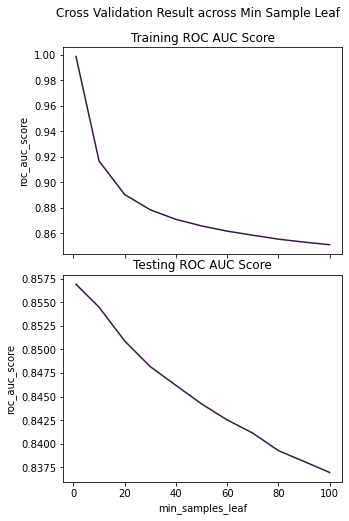

In [43]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5,8))
fig.suptitle("Cross Validation Result across Min Sample Leaf", y=0.95)

sns.lineplot(
    ax=axes[0],
    data=df_min_samples_leaf_tuning[df_min_samples_leaf_tuning['result'] == 'train'],
    x='min_samples_leaf',
    y="roc_auc_score",
)
axes[0].set_title("Training ROC AUC Score")

sns.lineplot(
    ax=axes[1],
    data=df_min_samples_leaf_tuning[df_min_samples_leaf_tuning['result'] == 'test'],
    x='min_samples_leaf',
    y="roc_auc_score",
)
axes[1].set_title("Testing ROC AUC Score")

plt.subplots_adjust(hspace=0.1)
plt.show()

<strong>Observations:</strong>
- As min_samples_leaf increases, both the ROC_AUC score of train and test data predictions decline, hence it is more optimal to keep min_samples_leaf low.
- However we would also want to prevent min_samples_leaf from being too low (make predictions only based on < 2 samples).
- <strong>Optimal min_samples_leaf: 3</strong>

### Model after Basic Tuning

In [43]:
rf2 = RandomForestClassifier(
    n_estimators=4000,           # default
    max_depth=20,             # default
    max_features="auto",        # default
    min_samples_leaf=3,         # do not want too little data in one leaf node
    criterion="entropy",        # covered in lecture
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


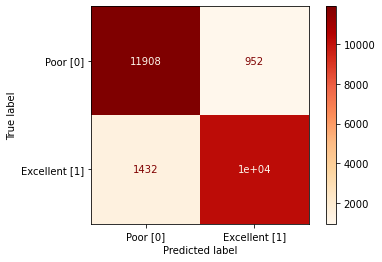

TN: 11908, FP: 952, FN: 1432, TP: 10156
Accuracy: 0.90249
Recall: 0.87642
Precision: 0.91430
F1: 0.89496
ROC_AUC: 0.97354


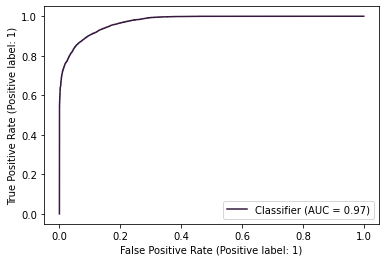

-------------------- Overall Test Result--------------------
Confusion Matrix:


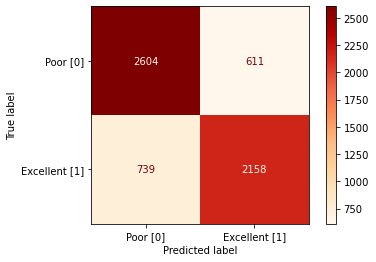

TN: 2604, FP: 611, FN: 739, TP: 2158
Accuracy: 0.77912
Recall: 0.74491
Precision: 0.77934
F1: 0.76174
ROC_AUC: 0.85866


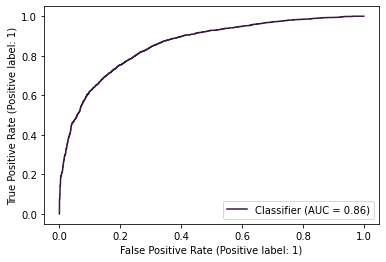

In [44]:
roc_auc_train_2, roc_auc_test_2 = stratified_k_fold_model_fit(X, y, rf2, 5, shuffle=True, hide_fold_result=True)

<strong>Observations:</strong>
- Train AUC decreases from 1.00 to 0.973
- Test AUC improved from 0.85015 to 0.85866
- Tuning of the 3 hyper-parameters reduced the extend of overfitting on training data, while improving the predictive power of the trained model.

### Analysing Feature Importances from Model

In [45]:
df_feature_importance = pd.DataFrame(list(zip(X.columns, rf2.feature_importances_)), columns=['features', 'importance'])
df_feature_importance['importance_pct'] = df_feature_importance['importance'] * 100

In [46]:
df_feature_importance.sort_values('importance_pct', ascending=False).iloc[:20,:]

,features,importance,importance_pct
99,average_sentiment_score,0.373334,37.333388
100,img_uploaded_per_review,0.079381,7.938121
104,walking_distance,0.063661,6.366101
94,total_operating_hours,0.035266,3.526622
23,price_category,0.022060,2.206011
103,is_in_mall,0.020753,2.075302
101,is_travellors_choice,0.015568,1.556807
95,num_of_days_open,0.012946,1.294617
83,has_features,0.010349,1.034890
70,feature_reservations,0.010141,1.014089


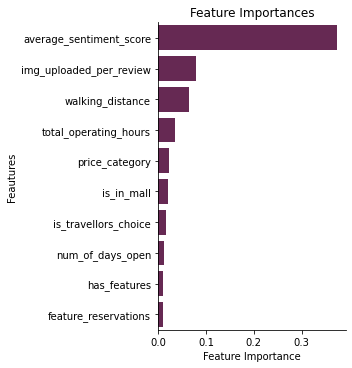

In [47]:
ax = sns.catplot(
    y = 'features',
    x = 'importance',
    data = df_feature_importance.sort_values(by=['importance'], ascending=False).head(10),
    kind='bar',
    # hue='feature_category',
    color=hex_colors[1]
)

# ax.fig.gca().set(xlim=(3.5,4.1))
ax.fig.gca().set_title("Feature Importances")
ax.fig.gca().set_ylabel("Feautures")
ax.fig.gca().set_xlabel("Feature Importance")
plt.show()

<strong>Observations:</strong>
- Average Sentiment Score significantly outweighs all other features in the dataset in terms of the trees' capabilities to "gain information" with it being the splitting criterion.
- It is also seen that "img_uploaded_per_review" has the second highest feature importances. This feature is a proxy of how "nice-looking" and photogenic a restaurant and/or their food is.
- Factors that are "controllable" by the restaurant owner, such as the location of the restarant (captured by features such as is_in_mall, walking_distance), features and cuisines offered, or operating hours or price plays a much lesser role in a restaurants' rating than average_sentiment_score.
- <strong> It is therefore important for restaurants to improve customer's overall sentiments/dining experience from dining in their restaurants. To do so we will use NLP to conduct a more detailed analysis to understand factors that could affect customer's sentiments.</strong>

In [48]:
df_feature_importance["feature_category"] = df_feature_importance["features"].map(dct_feature_category)

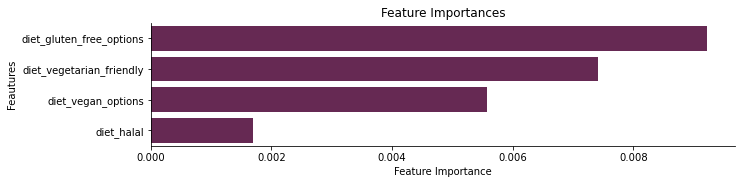

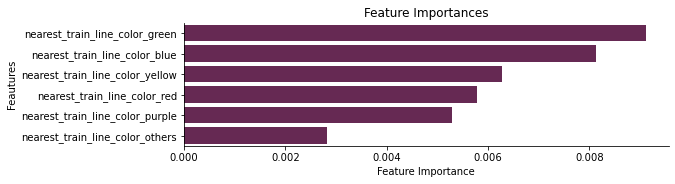

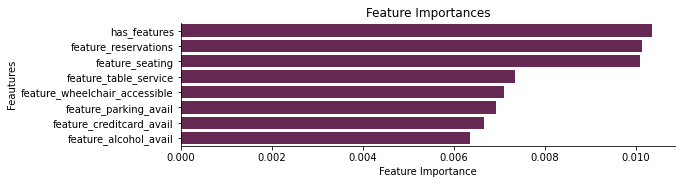

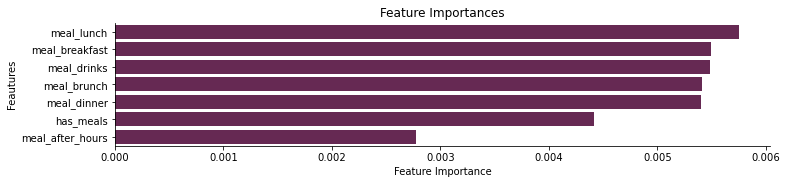

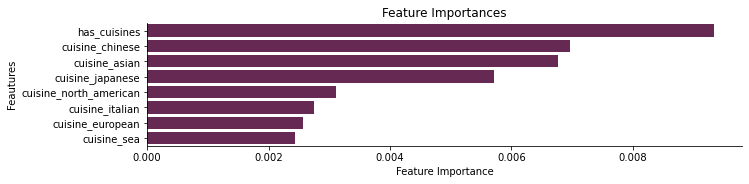

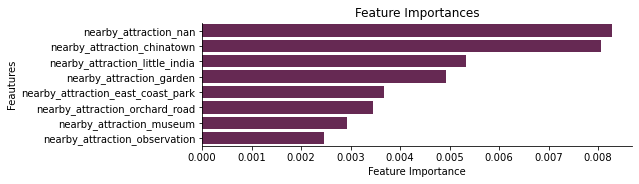

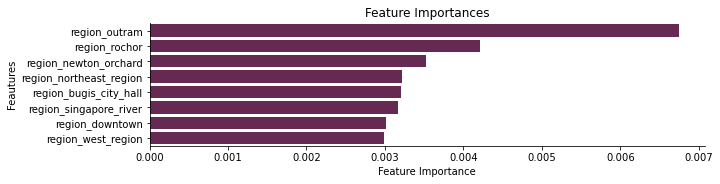

In [49]:
for i in ["Diet OHE", "Nearest Train Station Color OHE", "Feature OHE", "Meal OHE", "Cuisine OHE", "Nearby Attraction OHE", "Region OHE"]:
    ax = sns.catplot(
        y = 'features',
        x = 'importance',
        data = df_feature_importance[df_feature_importance["feature_category"]==i].sort_values(by=['importance'], ascending=False).head(8),
        kind='bar',
        # hue='feature_category',
        color=hex_colors[1]
    )

    # ax.fig.gca().set(xlim=(3.5,4.1))
    ax.fig.set_figheight(2)
    ax.fig.set_figwidth(15)
    ax.fig.gca().set_title("Feature Importances")
    ax.fig.gca().set_ylabel("Feautures")
    ax.fig.gca().set_xlabel("Feature Importance")
    plt.show()

## 4. Selecting Most Important Features

Selecting the Features that have a greater feature importance according to the earlier models built.

In [50]:
# ------------------- Feature Selection Cell --------------------- #
features_to_exclude = [
    'is_michellin',
    'operates_on_weekends',
    'operates_on_sat_or_sun',
]

features_to_exclude.extend(nearby_attraction_feature_cross)
features_to_exclude.extend(train_station_ohe)
features_to_exclude.remove("nearest_train_line_color_green")
features_to_exclude.remove("nearest_train_line_color_blue")

features_to_exclude.extend(region_ohe)
features_to_exclude.remove("region_outram")

features_to_exclude.append("meal_after_hours")
features_to_exclude.append("has_meals")

cuisines_ohe_subset = cuisine_ohe.copy()
cuisines_ohe_subset.remove("has_cuisines")
cuisines_ohe_subset.remove("cuisine_chinese")
cuisines_ohe_subset.remove("cuisine_asian")
cuisines_ohe_subset.remove("cuisine_japanese")
features_to_exclude.extend(cuisines_ohe_subset)

nearby_attraction_ohe_subset = nearby_attraction_ohe.copy()
nearby_attraction_ohe_subset.remove("nearby_attraction_chinatown")
nearby_attraction_ohe_subset.remove("nearby_attraction_nan")
features_to_exclude.extend(nearby_attraction_ohe_subset)

features_to_exclude.append("diet_halal")
features_to_exclude.append("diet_vegan_options")
features_to_exclude.append("diet_vegetarian_friendly")

### Model after Feature Selection

In [51]:
X2 = X.drop(columns=features_to_exclude)

In [52]:
X2.columns

Index(['region_outram', 'has_price_category', 'price_category',
       'nearby_attraction_chinatown', 'nearby_attraction_nan', 'meal_lunch',
       'meal_dinner', 'meal_drinks', 'meal_breakfast', 'meal_brunch',
       'cuisine_asian', 'cuisine_chinese', 'cuisine_japanese', 'has_cuisines',
       'feature_delivery', 'feature_reservations', 'feature_outdoor_seating',
       'feature_seating', 'feature_highchairs_available',
       'feature_digital_payments', 'feature_free_wifi', 'feature_cash_only',
       'feature_wheelchair_accessible', 'feature_table_service',
       'feature_live_music', 'feature_parking_avail', 'feature_alcohol_avail',
       'feature_creditcard_avail', 'has_features', 'diet_gluten_free_options',
       'nearest_train_line_color_blue', 'nearest_train_line_color_green',
       'total_operating_hours', 'num_of_days_open', 'has_operating_hours',
       'average_sentiment_score', 'img_uploaded_per_review',
       'is_travellors_choice', 'is_in_mall', 'walking_distance',

In [53]:
rf3 = RandomForestClassifier(
    n_estimators=4000,
    max_depth=20,
    max_features="auto",
    min_samples_leaf=3,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

-------------------- Overall Train Result--------------------
Confusion Matrix:


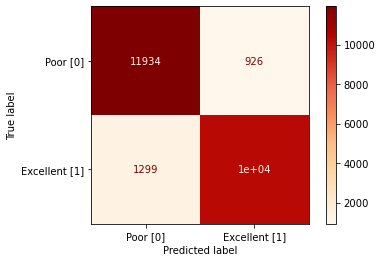

TN: 11934, FP: 926, FN: 1299, TP: 10289
Accuracy: 0.90899
Recall: 0.88790
Precision: 0.91743
F1: 0.90243
ROC_AUC: 0.97708


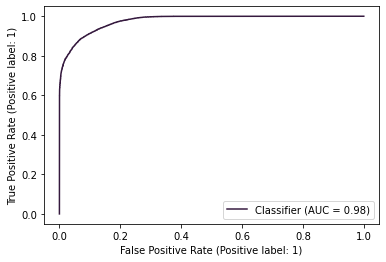

-------------------- Overall Test Result--------------------
Confusion Matrix:


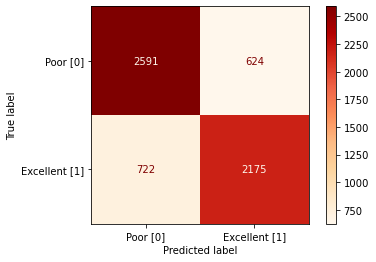

TN: 2591, FP: 624, FN: 722, TP: 2175
Accuracy: 0.77978
Recall: 0.75078
Precision: 0.77706
F1: 0.76369
ROC_AUC: 0.86018


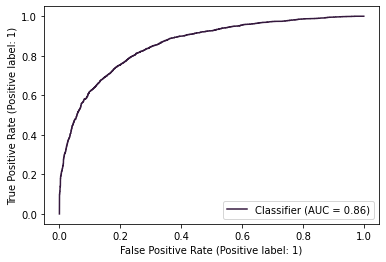

In [54]:
roc_auc_train_3, roc_auc_test_3 = stratified_k_fold_model_fit(X2, y, rf3, 5, shuffle=True, hide_fold_result=True)

<strong>Observations:</strong>
- Train AUC decreases from 1.00 to 0.973
- Reducing the features have resulted in an improvement in the model as the Test ROC_AUC increased from 0.85866 to 0.86018

In [55]:
df_feature_importance_2 = pd.DataFrame(list(zip(X2.columns, rf3.feature_importances_)), columns=['features', 'importance'])
df_feature_importance_2['importance_pct'] = df_feature_importance_2['importance'] * 100

In [56]:
df_feature_importance_2.sort_values('importance_pct', ascending=False)

,features,importance,importance_pct
35,average_sentiment_score,0.424490,42.448960
36,img_uploaded_per_review,0.103658,10.365796
39,walking_distance,0.089012,8.901228
32,total_operating_hours,0.045176,4.517627
2,price_category,0.025303,2.530266
38,is_in_mall,0.022703,2.270329
37,is_travellors_choice,0.016397,1.639653
33,num_of_days_open,0.016366,1.636582
40,above_median_dist_from_nearby_attraction,0.014206,1.420575
31,nearest_train_line_color_green,0.013652,1.365181


### Bayesian Optimisation Hyperparameter Tuning

Perform 2 rounds of Bayesian Optimisation Hyperparameter Tuning to achieve the best model possible

In [57]:
def hyperopt(X, Y, classifier, param_space, num_eval, splits=5, shuffle=False, verbose=True):
    '''
    Function to perform Bayesian Optimisation Hyper-Param Tuning
    '''
    start = time()
    def objective_function(params):
        clf = classifier(**params)
        train_score, test_score = stratified_k_fold_model_fit(X, Y, 
                                                                clf, 
                                                                splits=splits, 
                                                                shuffle=shuffle, 
                                                                plot_confusion_matrix=False, 
                                                                plot_roc=False, 
                                                                hide_fold_result=True, 
                                                                verbose=False)

        return {'loss': -test_score, 'status': STATUS_OK}
    trials = Trials()
    best_param = fmin(objective_function, param_space, algo=tpe.suggest, max_evals=num_eval, 
                      trials=trials, rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    # print(loss)
    return trials, best_param_values

In [58]:
def format_bayes_trial_df(model):
    '''
    Function to visualise Hyper-Parameter Tuning Trials
    '''
    trials = model[0].trials
    record = []
    losses = []
    for trial in trials:
        loss = trial["result"]["loss"]
        values = trial["misc"]['vals']
        losses.append(loss)
        record.append(values)
        
    bayesTrialsData = pd.DataFrame(record)
    bayesTrialsData.insert(0, 'loss', losses)
    non_loss_col = list(bayesTrialsData.columns)
    non_loss_col.remove('loss')
    for col in non_loss_col:
        bayesTrialsData[col] = bayesTrialsData[col].apply(
            lambda x: x[0]
        )
    return bayesTrialsData

##### Round 1

In [142]:
rf_hyperopt_1 = RandomForestClassifier(
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

In [143]:
param = {
    # Untuned Param
    'random_state': hp.choice('random_state', [2022]),
    'n_jobs': hp.choice('n_jobs', [-1]),
    'oob_score': hp.choice('oob_score', [True]),
    'bootstrap': hp.choice('bootstrap', [True]),
    
    # Tuned Param
    'criterion': hp.choice('criterion', ['entropy','gini']),
    'max_depth': scope.int(hp.quniform('max_depth', 16, 26, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 3700, 4300, 50)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 3, 20, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 3, 20, 1)),
    'max_features': scope.int(hp.quniform('max_features', 5, 40, 5)),

}

In [146]:
num_eval = 100

load = True #put load = True if you don't want to load the whole thing again
if(load == False):
    hyperopt_rf_results = hyperopt(X2, y, RandomForestClassifier, param, num_eval, shuffle=True)
    save_file('models/hyperopt_rf.pkl', hyperopt_rf_results)
else:
    try:
        hyperopt_rf_results = load_file('models/hyperopt_rf.pkl')
    except Exception as e:
        print(e)

100%|██████████| 100/100 [1:41:45<00:00, 61.06s/trial, best loss: -0.862333031940745]


In [147]:
df_hyperopt_rf_results = format_bayes_trial_df(hyperopt_rf_results)

In [152]:
df_hyperopt_rf_results.sort_values(by='loss', ascending=True).head(10)

,loss,bootstrap,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_jobs,oob_score,random_state
66,-0.862333,0,0,24.0,15.0,11.0,4.0,3750.0,0,0,0
33,-0.862326,0,0,24.0,15.0,10.0,9.0,3800.0,0,0,0
36,-0.862326,0,0,23.0,15.0,10.0,9.0,3800.0,0,0,0
25,-0.862318,0,0,23.0,15.0,11.0,7.0,3950.0,0,0,0
65,-0.862318,0,0,23.0,15.0,11.0,7.0,3950.0,0,0,0
60,-0.862294,0,0,22.0,15.0,12.0,15.0,4150.0,0,0,0
96,-0.862286,0,0,22.0,15.0,12.0,8.0,4100.0,0,0,0
29,-0.862273,0,0,26.0,15.0,12.0,7.0,3850.0,0,0,0
30,-0.862268,0,0,26.0,15.0,12.0,7.0,3800.0,0,0,0
68,-0.862268,0,0,25.0,15.0,12.0,3.0,3800.0,0,0,0


##### Round 2

In [156]:
param_2 = {
    # Untuned Param
    'random_state': hp.choice('random_state', [2022]),
    'n_jobs': hp.choice('n_jobs', [-1]),
    'oob_score': hp.choice('oob_score', [True]),
    'bootstrap': hp.choice('bootstrap', [True]),
    'criterion': hp.choice('criterion', ['entropy']),
    'max_features': hp.choice('max_features', ['auto', 15]),
    
    # Tuned Param
    'max_depth': scope.int(hp.quniform('max_depth', 22, 26, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 3750, 4150, 25)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 10, 12, 1)),
    'min_samples_split': scope.int(hp.quniform('min_samples_split', 3, 9, 1)),
}

In [158]:
num_eval = 50

load = True #put load = True if you don't want to load the whole thing again
if(load == False):
    hyperopt_rf_results_2 = hyperopt(X2, y, RandomForestClassifier, param_2, num_eval, shuffle=True)
    save_file('models/hyperopt_rf_2.pkl', hyperopt_rf_results_2)
else:
    try:
        hyperopt_rf_results_2 = load_file('models/hyperopt_rf_2.pkl')
    except Exception as e:
        print(e)

100%|██████████| 50/50 [47:36<00:00, 57.13s/trial, best loss: -0.8623478439696581]


In [159]:
df_hyperopt_rf_results_2 = format_bayes_trial_df(hyperopt_rf_results_2)

In [160]:
df_hyperopt_rf_results_2.sort_values(by='loss', ascending=True).head(10)

,loss,bootstrap,criterion,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,n_jobs,oob_score,random_state
45,-0.862348,0,0,25.0,1,10.0,6.0,3825.0,0,0,0
35,-0.862348,0,0,24.0,1,10.0,7.0,3825.0,0,0,0
36,-0.862348,0,0,24.0,1,10.0,6.0,3825.0,0,0,0
37,-0.862348,0,0,24.0,1,10.0,4.0,3825.0,0,0,0
32,-0.862344,0,0,22.0,1,10.0,8.0,3850.0,0,0,0
29,-0.862342,0,0,23.0,1,10.0,8.0,3850.0,0,0,0
30,-0.862342,0,0,24.0,1,10.0,7.0,3850.0,0,0,0
28,-0.862342,0,0,23.0,1,10.0,8.0,3850.0,0,0,0
20,-0.862338,0,0,23.0,1,11.0,9.0,3775.0,0,0,0
24,-0.862338,0,0,23.0,1,11.0,9.0,3775.0,0,0,0


In [33]:
hyperopt_rf_results_2 = load_file('models/hyperopt_rf_2.pkl')

In [34]:
hyperopt_rf_results_2

(<hyperopt.base.Trials at 0x7fc17c683d90>,
 {'bootstrap': 0,
  'criterion': 0,
  'max_depth': 24.0,
  'max_features': 1,
  'min_samples_leaf': 10.0,
  'min_samples_split': 7.0,
  'n_estimators': 3825.0,
  'n_jobs': 0,
  'oob_score': 0,
  'random_state': 0})

In [53]:
# from sklearn.model_selection import GridSearchCV

# rf_grid_search = RandomForestClassifier(
#     criterion='entropy',
#     bootstrap=True,
#     oob_score=True,
#     max_features=25,
#     min_samples_leaf=10,
#     random_state=2022,
#     n_jobs=-1
# )

# param_grid = {  
#     'n_estimators': [x for x in range(3820, 3855, 5)],
#     'min_samples_split': [x for x in range(4, 9)],
#     'max_depth': [x for x in range(23, 26)],
# }

# gridsearch_rf = GridSearchCV(
#     estimator=rf_grid_search,
#     param_grid=param_grid,
#     n_jobs=-1,
#     scoring='roc_auc',
#     cv=5,
#     verbose=3
# )

# gridsearch_rf.fit(X2, y)

### Performance of Best Random Forest Model on Hold-Out Test Data

In [59]:
final_rf_model = RandomForestClassifier(
    n_estimators=3825,  
    max_depth=25,       
    max_features=25,    
    min_samples_leaf=10,
    min_samples_split=6,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

In [60]:
final_rf_model_fit = final_rf_model.fit(X2, np.array(y).ravel())

X_holdout_sub = X_holdout[X2.columns]
y_pred_holdout = final_rf_model_fit.predict(X_holdout_sub)
y_proba_holdout = final_rf_model_fit.predict_proba(X_holdout_sub)[:, 1]

Confusion Matrix:


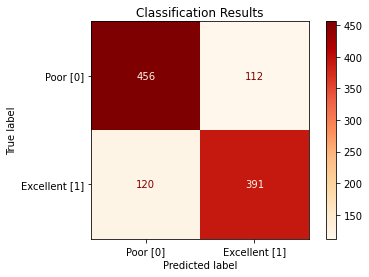

TN: 456, FP: 112, FN: 120, TP: 391
Accuracy: 0.78499
Recall: 0.76517
Precision: 0.77734
F1: 0.77120
ROC_AUC: 0.86785


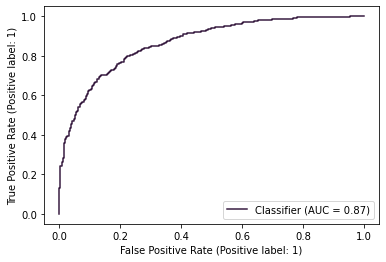

In [69]:
evaluate_results(y_holdout, y_pred_holdout, y_proba_holdout, plot_roc=True)

## 5. Analysing Feature Splits

### "Uncontrollable" But Most Significant Features
- average_sentiment_score
- img_uploaded_per_review

In [67]:
X_sub_1 = X[["average_sentiment_score", "img_uploaded_per_review"]].copy()

In [68]:
rf_sub_1 = RandomForestClassifier(
    n_estimators=3825,  
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=6,
    criterion="entropy",
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

In [69]:
roc_auc_train_sub_1, roc_auc_test_sub_1 = stratified_k_fold_model_fit(X_sub_1, y, rf_sub_1, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[10569  2291]
 [ 3395  8193]]
TN: 10569, FP: 2291, FN: 3395, TP: 8193
Accuracy: 0.76742
Recall: 0.70702
Precision: 0.78148
F1: 0.74239
ROC_AUC: 0.84575
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2627  588]
 [ 863 2034]]
TN: 2627, FP: 588, FN: 863, TP: 2034
Accuracy: 0.76260
Recall: 0.70211
Precision: 0.77574
F1: 0.73709
ROC_AUC: 0.83719


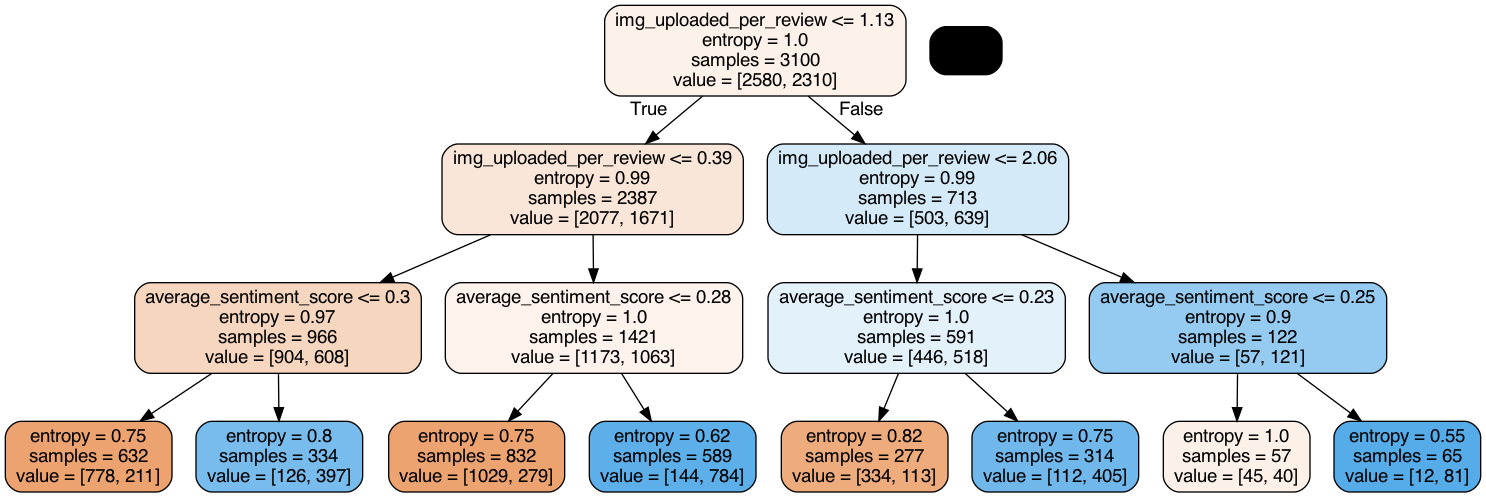

In [65]:
# Write the decision tree as a dot file
visual_tree = rf_sub_1.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_1.dot', feature_names = X_sub_1.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_1.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_1.png')

Image('image/random_forest_sub_1.png')

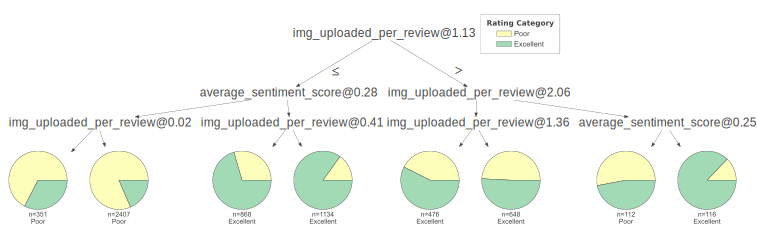

In [70]:
viz = dtreeviz(
    rf_sub_1.estimators_[0], 
    X_sub_1, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_1.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz

<strong>Sentiment</strong>
- < ~0.3 ==> Poor Restaurant

<strong>Images Uploaded</strong>
- Not noticeably important as compared to customer sentiment

### Locational Features
- walking_distance
- is_in_mall
- nearest_train_line_color_green
- nearest_train_line_color_blue

In [71]:
X_sub_2 = X[[
                "walking_distance", 
                "is_in_mall", 
                "nearest_train_line_color_green",
                "nearest_train_line_color_blue",
                ]].copy()

rf_sub_2 = RandomForestClassifier(
    n_estimators=3825,           
    max_depth=3,
    # max_features=10,      
    min_samples_leaf=6,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_2, roc_auc_test_sub_2 = stratified_k_fold_model_fit(X_sub_2, y, rf_sub_2, 5, shuffle=True,plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[6188 6672]
 [3473 8115]]
TN: 6188, FP: 6672, FN: 3473, TP: 8115
Accuracy: 0.58504
Recall: 0.70029
Precision: 0.54879
F1: 0.61536
ROC_AUC: 0.62638
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[1520 1695]
 [ 889 2008]]
TN: 1520, FP: 1695, FN: 889, TP: 2008
Accuracy: 0.57723
Recall: 0.69313
Precision: 0.54226
F1: 0.60848
ROC_AUC: 0.60926


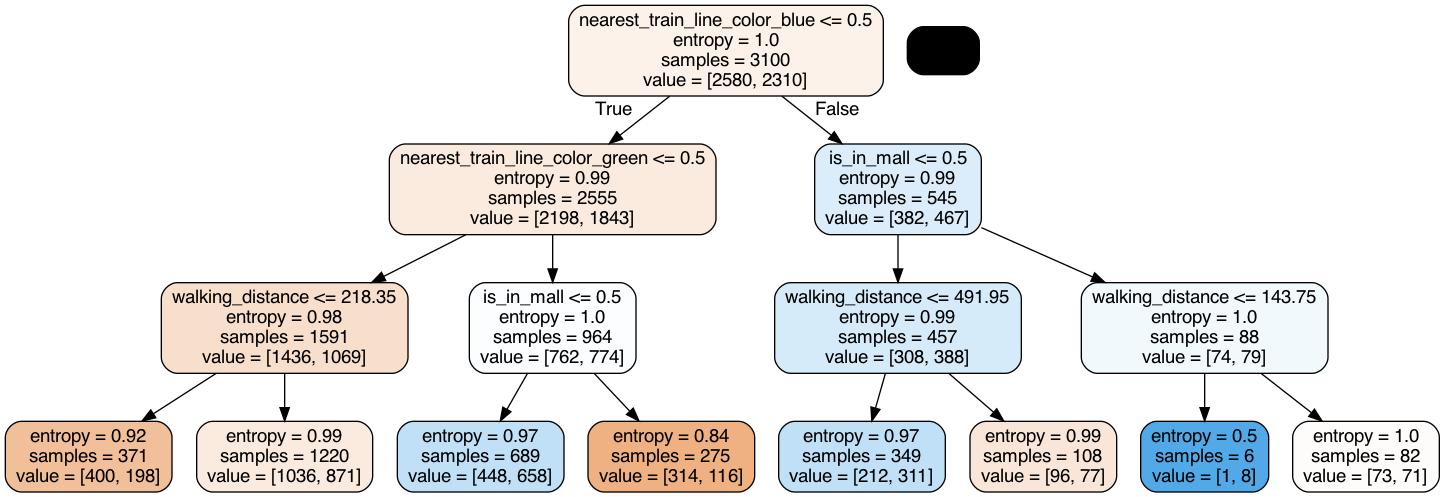

In [72]:
# Write the decision tree as a dot file
visual_tree = rf_sub_2.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_2.dot', feature_names = X_sub_2.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_2.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_2.png')

Image('image/random_forest_sub_2.png') 

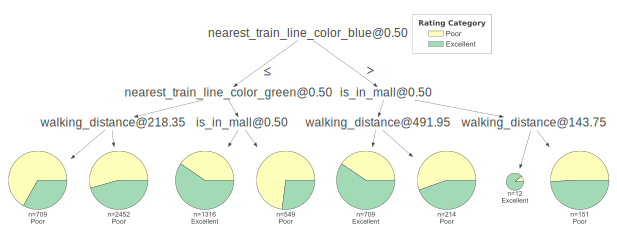

In [73]:
viz_2 = dtreeviz(
    rf_sub_2.estimators_[0], 
    X_sub_2, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_2.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_2

<strong>Downtown (Blue) Line</strong>
- Restaurants in Mall ==> Walking Distance from station exit > 140m ==> Poor
- Restaurants Not in Mall -> Walking Distance from station exit > 500m ==> Excellent

<strong>North East (Green) Line</strong>
- Restaurants in Mall ==> Poor
- Restaurants Not in Mall ==> Excellent 
(Likely caused by stations like Chinatown/ECP that has a large number of renowned eateries that are not in malls)

<strong>Other Lines</strong>
- Short walking distances (<50m) ==> Poor

### Price, Cuisine and Diet Features
- has_cuisines
- cuisine_chinese
- cuisine_asian
- cuisine_japanese
- price_category
- diet_gluten_free_options

In [74]:
X_sub_3 = X[[
            "price_category",
            "has_cuisines", 
            "cuisine_chinese", 
            "cuisine_asian", 
            "cuisine_japanese",
            "diet_gluten_free_options"
            ]].copy()

rf_sub_3 = RandomForestClassifier(
    n_estimators=3825,           
    max_depth=5,
    # max_features="auto",      
    min_samples_leaf=6,       
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_3, roc_auc_test_sub_3 = stratified_k_fold_model_fit(X_sub_3, y, rf_sub_3, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[11948   912]
 [ 9469  2119]]
TN: 11948, FP: 912, FN: 9469, TP: 2119
Accuracy: 0.57538
Recall: 0.18286
Precision: 0.69911
F1: 0.28990
ROC_AUC: 0.59543
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2976  239]
 [2365  532]]
TN: 2976, FP: 239, FN: 2365, TP: 532
Accuracy: 0.57395
Recall: 0.18364
Precision: 0.69001
F1: 0.29008
ROC_AUC: 0.58306


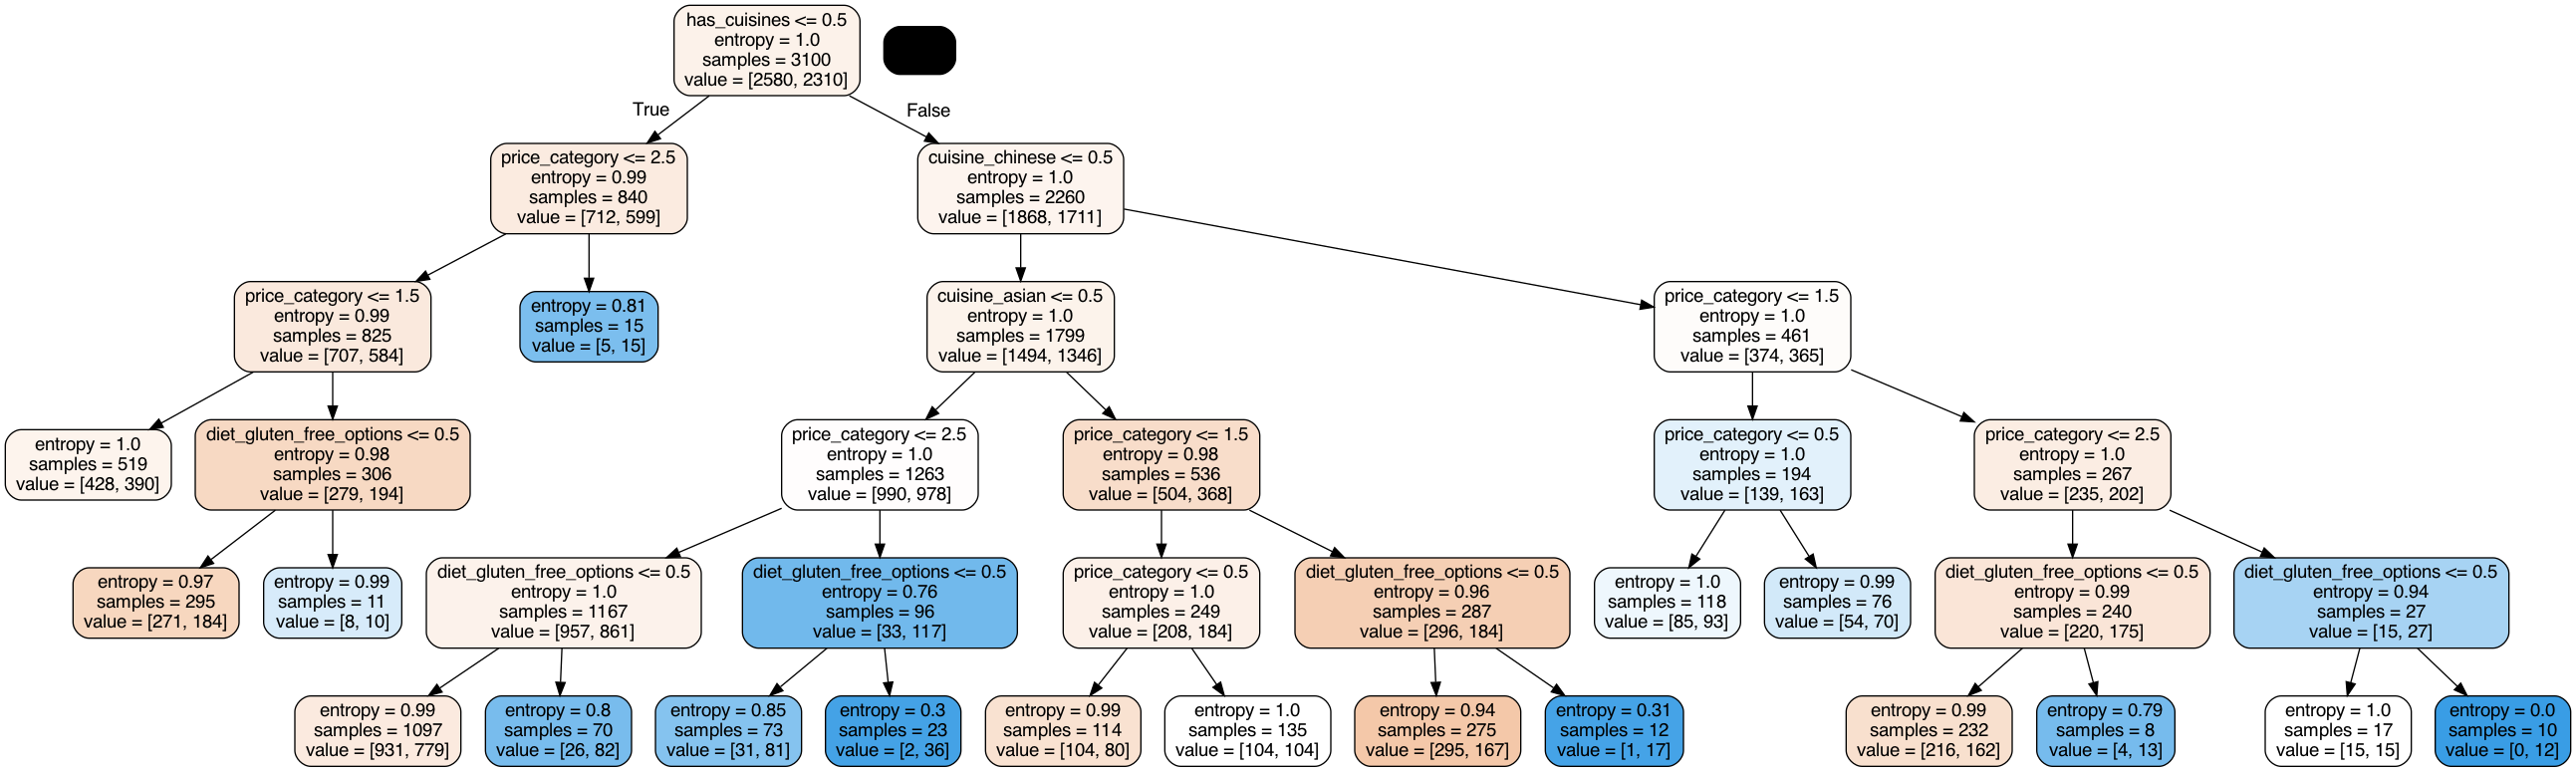

In [75]:
# Write the decision tree as a dot file
visual_tree = rf_sub_3.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_3.dot', feature_names = X_sub_3.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_3.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_3.png')

Image('image/random_forest_sub_3.png') 

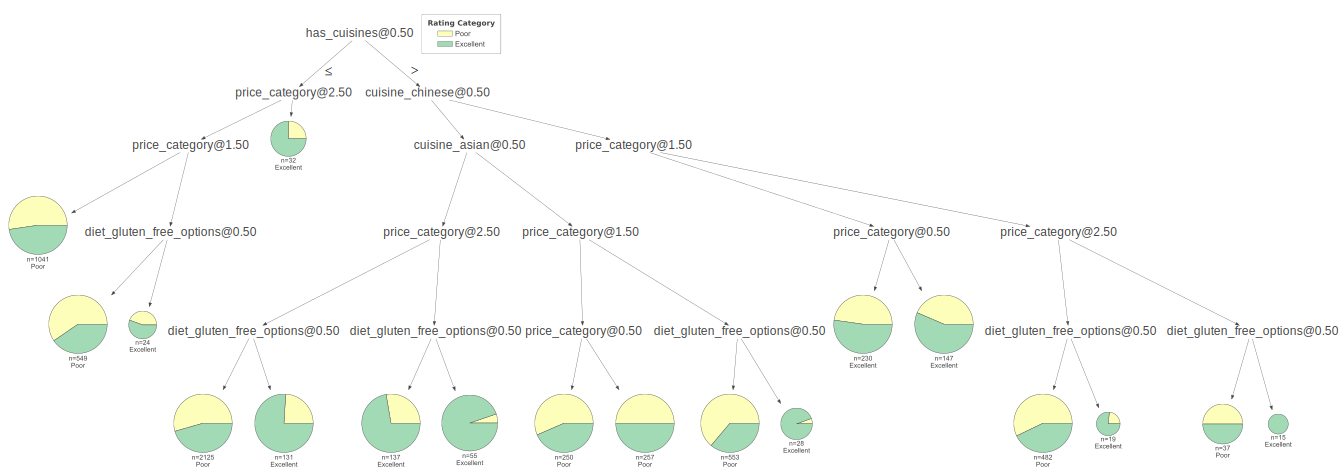

In [76]:
viz_3 = dtreeviz(
    rf_sub_3.estimators_[0], 
    X_sub_3, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_3.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_3

<strong>Gluten Free Options Diet</strong>
- True ==> Excellent
- False ==> Poor

<strong>Price Category</strong>
- For Japanese Cuisine, < 3 ==> Poor, 3 => Excellent (Non Gluten Free)
- For Chinese Cuisine 0 ==> Poor, 1 ==> Excellent, >= 2 ==> Poor (Non Gluten Free)
Diners are less willing to spend a large amount of money for Chinese Cuisines as compared to Japanese Cuisines. For Japanese cuisines, a restaurant that has higher prices are much more likely to provide services that appeal to diners.

### Meal and Operating Hours Features
- meal_dinner
- meal_lunch
- meal_brunch
- meal_breakfast
- meal_drinks
- total_operating_hours
- num_of_days_open

In [77]:
X_sub_4 = X[[
    "meal_dinner",
    "meal_lunch",
    "meal_brunch",
    "meal_breakfast",
    "meal_drinks",
    "total_operating_hours", 
    "num_of_days_open"
    ]].copy()

rf_sub_4 = RandomForestClassifier(
    n_estimators=3825,           
    max_depth=5,
    min_samples_leaf=6,
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_4, roc_auc_test_sub_4 = stratified_k_fold_model_fit(X_sub_4, y, rf_sub_4, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[9816 3044]
 [6762 4826]]
TN: 9816, FP: 3044, FN: 6762, TP: 4826
Accuracy: 0.59890
Recall: 0.41647
Precision: 0.61321
F1: 0.49604
ROC_AUC: 0.63448
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2425  790]
 [1714 1183]]
TN: 2425, FP: 790, FN: 1714, TP: 1183
Accuracy: 0.59031
Recall: 0.40835
Precision: 0.59959
F1: 0.48583
ROC_AUC: 0.61699


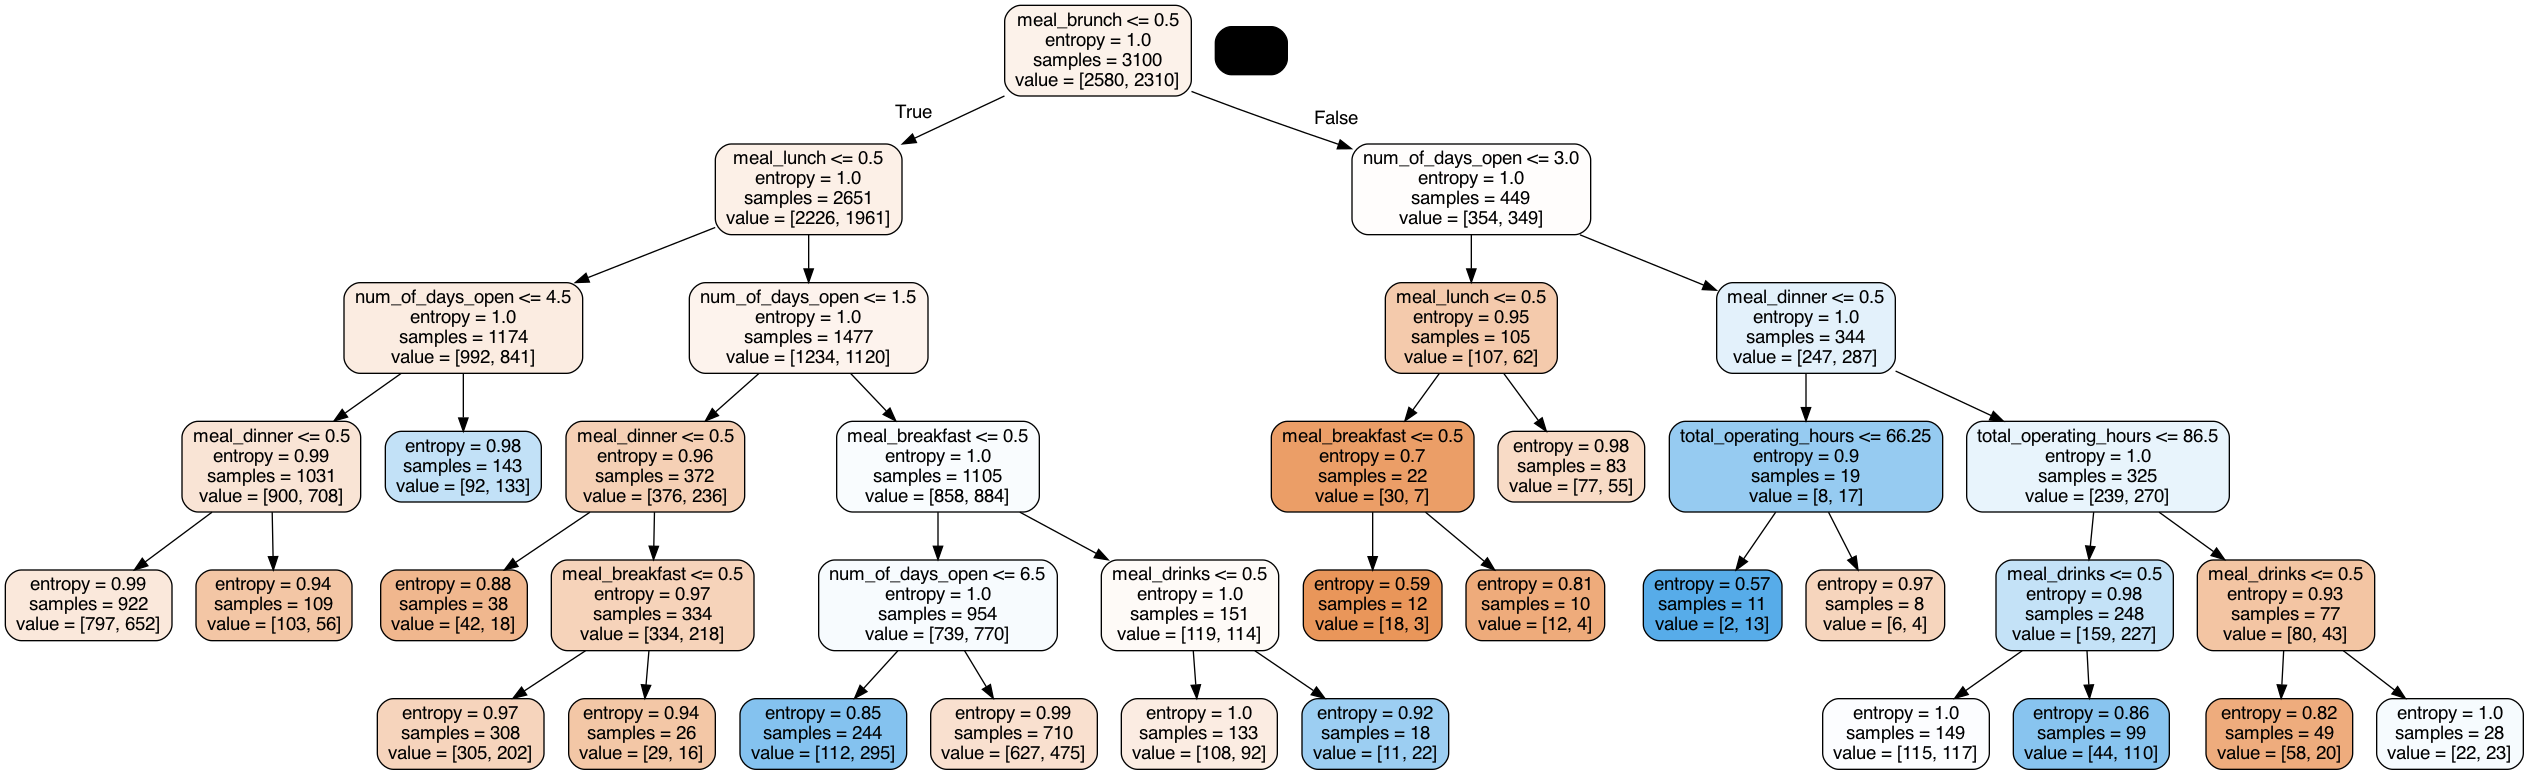

In [78]:
# Write the decision tree as a dot file
visual_tree = rf_sub_4.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_4.dot', feature_names = X_sub_4.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_4.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_4.png')

Image('image/random_forest_sub_4.png') 

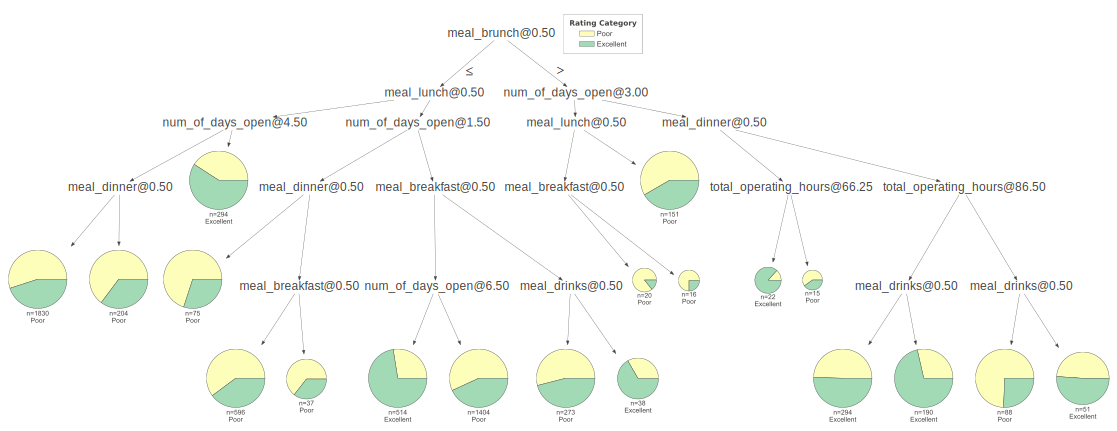

In [79]:
viz_4 = dtreeviz(
    rf_sub_4.estimators_[0], 
    X_sub_4, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_4.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_4

<strong>Number of Days Open</strong>
- For Restaurants that provide Brunch, <= 3 ==> Poor
(Some Customers may take these restaurants as their "go-to" for Brunch/Lunch hence prefer more operating days)
- For Restaurants that provide Lunch but not Breakfast, < 7 ==> Excellent, 7 ==> Poor
(Restaurants that operate 7-days a week maybe less "premium")

<strong>Meals_Drinks</strong>
- For Restaurants that provide Dinner, Provide Drinks ==> Excellent
- For Restaurants that provide Lunch and Breakfast, Provide Drinks ==> Excellent

<strong>Total Operating Hours</strong>
- For Restaurants that provide Brunch and Dinner, too long of total operating hours => Poor 
(Maybe these restaurants have less time to clean up their restaurants, or provide training to staffs leading to less ideal services provided)

### Services Features
- feature_delivery
- feature_reservations
- feature_outdoor_seating,
- feature_seating
- feature_highchairs_available
- feature_digital_payments
- feature_free_wifi
- feature_cash_only
- feature_wheelchair_accessible
- feature_table_service
- feature_live_music
- feature_parking_avail
- feature_alcohol_avail
- feature_creditcard_avail
- has_features

In [83]:
X_sub_5 = X[['feature_delivery', 'feature_reservations', 'feature_outdoor_seating',
       'feature_seating', 'feature_highchairs_available',
       'feature_digital_payments', 'feature_free_wifi', 'feature_cash_only',
       'feature_wheelchair_accessible', 'feature_table_service',
       'feature_live_music', 'feature_parking_avail', 'feature_alcohol_avail',
       'feature_creditcard_avail', 'has_features']].copy()

rf_sub_5 = RandomForestClassifier(
    n_estimators=3825,           
    max_depth=4,
    min_samples_leaf=6,
    criterion="entropy",  
    bootstrap=True,
    oob_score=True,
    random_state=2022,
    n_jobs=-1
)

roc_auc_train_sub_5, roc_auc_test_sub_5 = stratified_k_fold_model_fit(X_sub_5, y, rf_sub_5, 5, shuffle=True, plot_confusion_matrix=False, plot_roc=False, hide_fold_result=True)

-------------------- Overall Train Result--------------------
Confusion Matrix:
[[11232  1628]
 [ 8619  2969]]
TN: 11232, FP: 1628, FN: 8619, TP: 2969
Accuracy: 0.58087
Recall: 0.25621
Precision: 0.64586
F1: 0.36688
ROC_AUC: 0.62029
-------------------- Overall Test Result--------------------
Confusion Matrix:
[[2794  421]
 [2162  735]]
TN: 2794, FP: 421, FN: 2162, TP: 735
Accuracy: 0.57739
Recall: 0.25371
Precision: 0.63581
F1: 0.36269
ROC_AUC: 0.60918


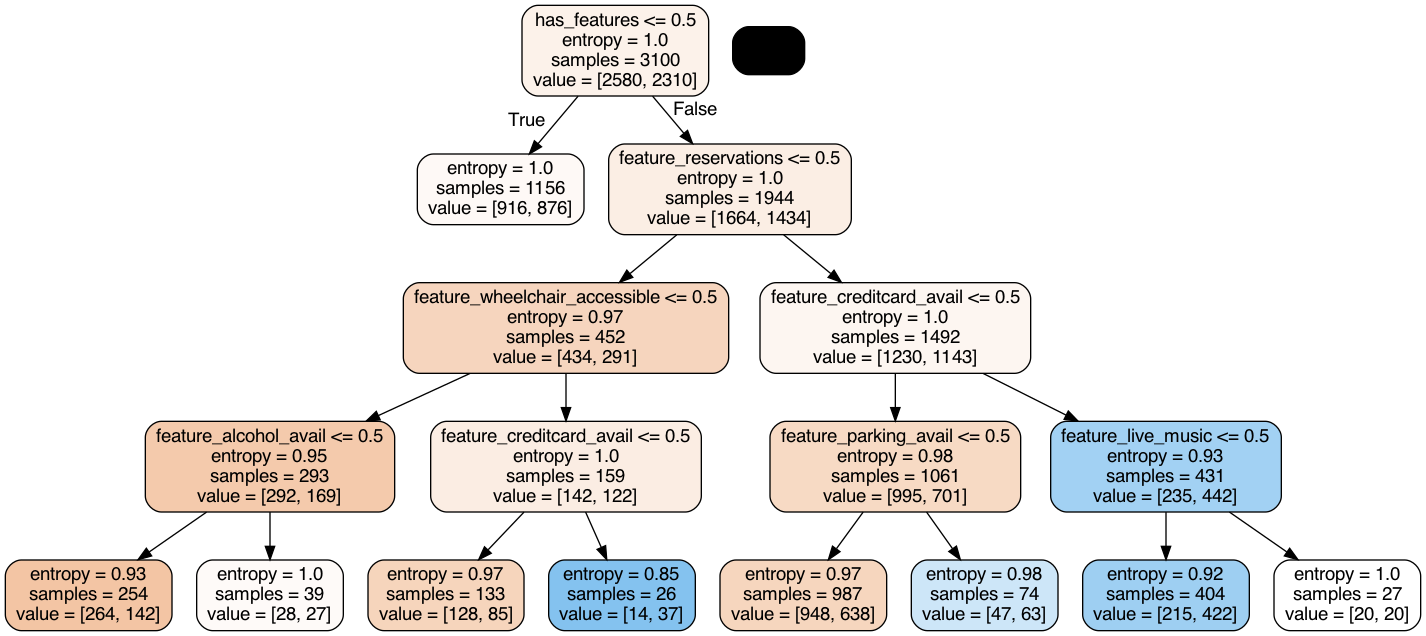

In [84]:
# Write the decision tree as a dot file
visual_tree = rf_sub_5.estimators_[0]
export_graphviz(visual_tree, out_file = 'image/random_forest_sub_5.dot', feature_names = X_sub_5.columns, 
                precision = 2, filled = True, rounded = True, max_depth = None)

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('image/random_forest_sub_5.dot')

# MacOs need to brew install gprof2dot
graph.write_png('image/random_forest_sub_5.png')

Image('image/random_forest_sub_5.png')

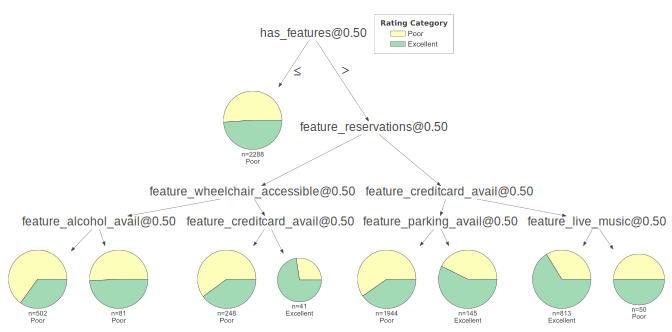

In [85]:
viz_5 = dtreeviz(
    rf_sub_5.estimators_[0], 
    X_sub_5, y['average_rating_category'],
    target_name="Rating Category",
    feature_names=X_sub_5.columns,
    class_names=["Poor", "Excellent"],
    fancy=False,
)

viz_5

<strong>Credit Card Payment Available</strong>
- False ==> More Poor
- True ==> More Excellent
(Customers prefer Cash-Free payment options)

<strong>Parking Available</strong>
- False ==> Poor
- True ==> Excellent
(Accessible for drivers)